# Metastasis free survival prediction using transcriptomics and proteomics data from the `APOLLO-LUAD` study

## Approach 
- Based on multimodal cancer modeling, described here https://arxiv.org/abs/2505.07683
- Fit CoxPH model on zero-shot embeddings extracted from survival protein and survival RNA expression from `APOLLO-LUAD`
- `APOLLO-LUAD` paper, `Soltis et al 2022`  https://gdc.cancer.gov/about-data/publications/APOLLO-LUAD-2022

## Analysis scheme

### Survival RNA expression
- get RNA expression data for each patient from GDC portal
- embed with bulkRNABERT model n=256 dims, only considering expression for survival RNAs (n=155)
- embeddings accessible via APIs, pull from API and join with usable clinical data ( MFS survival data )
- fit coxPH model: X => RNA expressions, y -> Dead/Alive, survival time in months for metastasis free survival (MFS)
- split data into train and test (0.2)
- scale training data and reduce using PCA (`X_train_red_rna`)
- fit cox model `cox_rna` on reduced training data
- use `cox_rna` to predict risk scores on `X_test_red_rna` (`y_test_pred_rna`)
- calculate C-index between `y_test_rna` and `y_test_pred_rna`

### Survival Protein
- repeat the same analysis as RNA, except with survival protein data (n=560) and PCA embeddings

###  Survival RNA + Survival Protein
- combine risk scores from the two modalities, fit coxPH model and recalculate C-index

### All RNAs
- same analysis as survival RNA expression, but using all RNAs (n ~ 19K)

### All Proteins
- same analysis as survival proteins, but using all proteins (n ~ 7.6K)

### All RNAs + All Proteins
- combine risk scores from the two modalities, fit coxPH model and recalculate C-index

### C-index comparisons

#### Compare
- C-index from survival RNA-Seq embeddings from bulkRNABERT
- C-index from survival protein embeddings from PCA
- C-index from survival RNA-Seq + survival proteins (proteomics + transcriptomics)
- C-index from all RNA embeddings
- C-index from all protein embeddings
- C-index from all RNA embeddings + all protein embeddings

### Combined plot
- calculate a median risk score and partition the test set into high risk (>median) and low risk (< median)
- plot survival curves for the two groups for various combinations above

## Install libraries

In [1]:
!pip install pandas numpy tqdm matplotlib scikit-learn scikit-survival openpyxl xlrd

Defaulting to user installation because normal site-packages is not writeable


### Path to precomputed embeddings and supplementary files

In [ ]:
data_root = '/home/jovyan/pd/apollo_luad'

### Import libraries

In [3]:
import pandas as pd
import os
import numpy as np
import requests
import json
from tqdm import tqdm
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_censored
from gen3.auth import Gen3Auth


In [4]:
tqdm.pandas()

## Survival RNA analysis

### Read supplementary table S2C with MFS data

In [ ]:
table_s2c = pd.read_excel(os.path.join(data_root, 'data/1-s2.0-S2666379122003780-mmc3.xlsx'), sheet_name='TableS2C.APOLLO.MFS')

### Retrieve survival RNA embeddings using the MC2DP embedding service

In [6]:
auth = Gen3Auth(refresh_file=os.path.join(data_root, 'mc2dp_creds.json'))

In [7]:
def query(guid):
    with requests.Session() as session:
        try:
            response = session.get(
                f"https://mc2dp.data-commons.org/user/data/download/{guid}",
                auth=auth,
            )
            response.raise_for_status()
        except requests.exceptions.Timeout as e:
            print(f"Session request timed out: {e}")
    return response.json()["url"]

In [ ]:
# takes around 14 secs on GPU cluster
expr_embs = dict()
for fpath, embs, do_upper in [
    (os.path.join(data_root, 'data/apollo_luad_RNASeq_embeddings.json'), expr_embs, False),
]:
    with open(fpath, "r") as f:
        guids = [x["guid"] for x in json.load(f)]
    temp = [query(g) for g in guids]
    for x in tqdm(temp):
        fid = x["file_id"]
        if do_upper:
            fid = fid.upper()
        embs[fid] = np.asarray(json.loads(x["embedding"]))

100%|██████████| 87/87 [00:00<00:00, 12205.39it/s]


In [9]:
# embeddings for 87 patients
len(embs.keys())

87

### Read clinical data for MFS from supplement
- create survival MFS time in months

In [ ]:
table_s1 = pd.read_excel(os.path.join(data_root, 'data/1-s2.0-S2666379122003780-mmc2.xls'), sheet_name='Table S1A Sample Information')

In [11]:
average_days_per_month = 30.44
table_s1['surv_mfs_time_months'] = table_s1['surv_mfs_time'] / average_days_per_month

In [12]:
table_s1.head(n=2)

,caseId,normal_dna_sampleId,normal_dna_description,tumor_dna_sampleId,tumor_dna_description,tumor_rna_sampleId,tumor_rna_description,Tumor.Total.PF.reads,Tumor.Total.PF.bases,Tumor.Percent.Q30.bases,...,Post.Baseline.Chemo,ESTIMATEScore_protein,ESTIMATEScore_rna,TumorPurity_protein,TumorPurity_rna,ImmuneScore_rna,ImmuneScore_protein,StromalScore_rna,StromalScore_protein,surv_mfs_time_months
0,AP-27JZ,46-13654,46-13654-AP-27JZ-2V-G06,46-13708,46-13708-AP-27JZ-RD-E01,46-16376,46-16376-AP-27JZ-RD-D10,2923248624,437472245354,91.91,...,Cisplatin+Vinorelbine: (1 months post op),2071.880789,44069.893355,0.614444,0.703312,23196.581654,1534.210625,20873.311701,537.670164,42.148489
1,AP-2E8Q,46-13652,46-13652-AP-2E8Q-DR-E06,46-13757,46-13757-AP-2E8Q-QW-F07,46-16397,46-16397-AP-2E8Q-QW-F7,2917739886,436873821946,92.71,...,NaN,-1090.373605,39323.905746,0.902640,0.995576,20899.554918,-818.152318,18424.350828,-272.221288,39.586071


### Join survival RNA embeddings with clinical data 
- map `file_id` from embeddings to `submitter_id`

In [13]:
def map_file_id_to_submitter_id(file_name, suffix):
    file_name = file_name + suffix
    api_endpt = 'https://api.gdc.cancer.gov/files'
    fields = [
        "cases.submitter_id"
    ]
    fields = ",".join(fields)

    filters = {
        "op": "and",
          "content": [
              {
                "op": "in",
                "content": {"field": "file_name", "value": file_name},
              }
          ]
    }
    params = {"filters": json.dumps(filters), "fields": fields, "size": 10}
    try:
      response = requests.get(api_endpt, params=params)
      response_json = json.loads(response.content)
      submitter_id = response_json['data']['hits'][0]['cases'][0]['submitter_id']
    except Exception as e:
       print(f'unable to execute request, exception {str(e)}')
    return submitter_id

In [14]:
expr_df = pd.DataFrame(list(embs.keys()), columns=['file_id'])

In [15]:
expr_df.head()

,file_id
0,3cd3fbb2-8eb1-4fd0-ae5f-c940ae00e311
1,ac520fab-3a58-45b5-887a-b65127c8d7ba
2,1d723ebe-46f0-4788-8898-98e02df8beb1
3,b612e131-876c-4004-869a-b4cf59c22c6f
4,84315f98-9366-4174-be54-3cdd1fd9db07


In [16]:
expr_df['submitter_id'] = expr_df['file_id'].progress_apply(
    lambda x: map_file_id_to_submitter_id(x, suffix='.rna_seq.augmented_star_gene_counts.tsv')
)

100%|██████████| 87/87 [00:21<00:00,  4.06it/s]


In [17]:
expr_df.head()

,file_id,submitter_id
0,3cd3fbb2-8eb1-4fd0-ae5f-c940ae00e311,AP-52RG
1,ac520fab-3a58-45b5-887a-b65127c8d7ba,AP-HKYN
2,1d723ebe-46f0-4788-8898-98e02df8beb1,AP-5JDU
3,b612e131-876c-4004-869a-b4cf59c22c6f,AP-E98M
4,84315f98-9366-4174-be54-3cdd1fd9db07,AP-QAHT


In [18]:
expr_df[expr_df['submitter_id'].isnull()]

,file_id,submitter_id


In [19]:
expr_df_mfs = pd.merge(
    table_s1[['caseId', 'surv_mfs_usable']],
    expr_df,
    left_on=['caseId'],
    right_on=['submitter_id'],
    how='inner'
)

In [20]:
expr_df_mfs.head()

,caseId,surv_mfs_usable,file_id,submitter_id
0,AP-27JZ,True,46c96724-b37b-46c0-9cae-a4a1a5604bf0,AP-27JZ
1,AP-2E8Q,True,16e7a941-58dd-424b-90d4-766ed2538e61,AP-2E8Q
2,AP-2XNK,True,da9d049f-5aa3-4131-a2ff-092c78eed32a,AP-2XNK
3,AP-3336,True,f7683b51-cca9-4079-9e34-b9a4fdd27d85,AP-3336
4,AP-352Q,True,97abcebb-f885-4eca-9af4-91a0adb97578,AP-352Q


In [21]:
expr_df_mfs.shape

(87, 4)

### Extract embeddings for each case and create matrix for training using usable clinical data

In [22]:
def extract_case_emb(embs, file_ids: list[str]):
    X = []
    for fid in tqdm(file_ids):
        # if there are more than one embeddings stack them
        dims = embs[fid].ndim
        if dims > 1:
            embs = np.stack([embs[fid][i] for i in range(dims)], axis=0)
            emb = np.mean(embs, axis=0)
        else:
            emb = embs[fid]
        X.append(emb)
    return np.stack(X, axis=0)

In [23]:
mfs_usable_file_ids = list(expr_df_mfs[expr_df_mfs['surv_mfs_usable'] == True]['file_id'])

In [24]:
len(mfs_usable_file_ids)

83

In [25]:
expr_X = extract_case_emb(embs, mfs_usable_file_ids)

100%|██████████| 83/83 [00:00<00:00, 296783.66it/s]


In [26]:
expr_X.shape

(83, 256)

In [27]:
expr_X[:3, :3]

array([[-0.04291045,  0.48185515,  0.41139957],
       [-0.19191696,  0.49528143,  0.43106562],
       [-0.13372225,  0.5278174 ,  0.33739313]])

### Ensure order of cases in clinical data matches expression matrix

In [28]:
table_s1_usable = table_s1[table_s1['surv_mfs_usable']]

In [29]:
table_s1_usable.shape

(83, 238)

In [30]:
table_s1_usable = table_s1_usable[['caseId', 'surv_mfs_stat', 'surv_mfs_time', 'surv_mfs_time_months', 'surv_mfs_usable']]

In [31]:
mfs_usable_submitter_ids = list(expr_df_mfs[expr_df_mfs['surv_mfs_usable'] == True]['submitter_id'])
mfs_usable_submitter_ids == table_s1_usable['caseId'].to_list()

True

### Fit CoxPH model on survival RNA embeddings

In [32]:
y = Surv.from_arrays(event=table_s1_usable['surv_mfs_stat'].astype(bool),
                     time=table_s1_usable['surv_mfs_time_months']
                     )
X = expr_X

In [33]:
# train/test split
X_train_rna, X_test_rna, y_train_rna, y_test_rna = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [34]:
scaler = StandardScaler()
X_train_scaled_rna = scaler.fit_transform(X_train_rna)
X_test_scaled_rna = scaler.transform(X_test_rna)

In [35]:
X_train_scaled_rna.shape

(66, 256)

In [36]:
X_test_scaled_rna.shape

(17, 256)

In [37]:
pca_components = 66
pca = PCA(n_components=pca_components, random_state=42, svd_solver='full')
X_train_red_rna = pca.fit_transform(X_train_scaled_rna)
X_test_red_rna = pca.transform(X_test_scaled_rna)

In [38]:
cox_rna = CoxPHSurvivalAnalysis(alpha=0.1).fit(X_train_red_rna, y_train_rna)

In [39]:
cox_rna

CoxPHSurvivalAnalysis(alpha=0.1)

In [40]:
# predict risk scores
y_train_pred_rna = cox_rna.predict(X_train_red_rna)
y_test_pred_rna = cox_rna.predict(X_test_red_rna)

In [41]:
# extract survival time and bool for death
y_test_events = np.array([bool(data[0]) for data in y_test_rna])
y_test_time = np.array([data[1] for data in y_test_rna])

### Calculate C-index for survival RNAs

In [42]:
c_index = concordance_index_censored(
    event_indicator=y_test_events,
    event_time=y_test_time,
    estimate=y_test_pred_rna,
)[0]


In [43]:
c_index

0.6956521739130435

## Survival Protein analysis

### Read data for survival proteins and create dataframe

In [ ]:
protein_expr = pd.read_csv(os.path.join(data_root, 'data/APOLLO1_Level3_Gprot_v061418.n87.csv'), index_col=0)

In [45]:
protein_expr.shape

(7631, 90)

In [46]:
protein_expr.head(n=2)

,Accession,Protein,Gene,AP.JK59.P1,AP.7KJ6.P1,AP.KXUT.P1,AP.E98M.P1,AP.B2SL.P1,AP.QUHC.P1,AP.QAHT.P1,...,AP.DN2V.P9,AP.HML4.P9,AP.LWHD.P10,AP.DM87.P10,AP.9PXS.P10,AP.8MWD.P10,AP.EPNF.P10,AP.YF3B.P10,AP.4HAU.P10,AP.27JZ.P10
1,A0A075B6I0,LV861_HUMAN Immunoglobulin lambda variable 8-6...,IGLV8-61,0.050654,0.366505,2.623979,-0.488799,-1.354112,-0.272630,-0.480858,...,0.02126,-1.579249,-0.232252,0.245913,0.291053,1.073534,0.595459,0.598004,-0.671616,1.119084
2,A0A075B6K5,LV39_HUMAN Immunoglobulin lambda variable 3-9 ...,IGLV3-9,-0.083365,0.479073,0.029515,-0.027946,-0.319084,-0.141916,-0.038759,...,0.01241,-0.089523,-0.282970,-1.075871,-0.371070,3.672647,-0.316577,0.673816,-0.104036,-0.502964


In [47]:
survival_proteins = table_s2c[table_s2c['Protein_signature'] == 1]

In [48]:
survival_proteins.shape

(560, 24)

In [49]:
survival_proteins.head(n=2)

,Gene,RNA_platform,MSproteomics_platform,MSphosphoproteomics_platform,RPPA_platform,rnaCoxBeta,rnaCoxPhP,rnaCoxPhP_FDR,pepCoxBeta,pepCoxPhP,...,rppaCoxPhP,rppaCoxPhP_FDR,rppaCoxPhP_Phos_FDR,RPPA_Original_AbID,phosCoxBeta,phosCoxPhP,phosCoxPhP_FDR,RNA_signature,Protein_signature,RNA_Protein_signature
7,AADAC,1,1,0,0,-0.328390,0.007194,0.275799,-0.527966,0.010975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
10,AAGAB,1,1,0,0,0.334944,0.370815,0.765466,0.833652,0.010727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0


In [50]:
survival_proteins['accession'] = survival_proteins['Gene'].apply(
    lambda x: protein_expr[protein_expr['Gene'] == x]['Accession'].iloc[0]
)

/tmp/ipykernel_254/2257809051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_proteins['accession'] = survival_proteins['Gene'].apply(


In [51]:
survival_protein_names = survival_proteins['accession'].to_list()

In [52]:
len(set(survival_protein_names))

560

### Rearrange dataframe for PCA

In [53]:
protein_expr_t = protein_expr.T.reset_index().iloc[3:,:]

In [54]:
new_colnames = ['protein_sample_id'] + protein_expr['Accession'].to_list()
protein_expr_t.columns = new_colnames
protein_expr_t.head(n=3)

,protein_sample_id,A0A075B6I0,A0A075B6K5,A0A0A0MS15,A0A0B4J1U7,A0A0B4J1V0,A0A0B4J1X5,A0A0B4J2H0,A0A0C4DH29,A0A0C4DH31,...,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X3,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
3,AP.JK59.P1,0.050654,-0.083365,-0.850491,0.203472,-0.090884,0.166652,-0.378265,-0.624482,-0.515171,...,0.01124,0.611982,-0.186305,-0.288147,1.823572,1.333396,-0.506079,-0.775972,-0.497415,0.49844
4,AP.7KJ6.P1,0.366505,0.479073,-0.233867,-0.014184,-0.434559,-0.007123,0.719558,1.298673,0.555491,...,0.209892,0.509745,0.621954,-0.488953,0.509972,-0.437719,0.681508,0.6743,-0.440925,-0.184505
5,AP.KXUT.P1,2.623979,0.029515,1.724429,1.06434,0.101535,0.445541,0.037209,0.299001,-0.632489,...,0.049517,0.069769,0.238788,-0.446452,-0.482565,-0.236125,0.091455,-0.296821,-0.40941,0.113418


### Join protein expression data with clinical data

In [55]:
# align case ids in protein_expr data with Table S1A
protein_expr_t['caseId'] = protein_expr_t['protein_sample_id'].apply(
    lambda x: '-'.join(x.split('.')[:2])
)

In [56]:
protein_expr_t.head(n=3)

,protein_sample_id,A0A075B6I0,A0A075B6K5,A0A0A0MS15,A0A0B4J1U7,A0A0B4J1V0,A0A0B4J1X5,A0A0B4J2H0,A0A0C4DH29,A0A0C4DH31,...,Q9Y6W3,Q9Y6W5,Q9Y6X3,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8,caseId
3,AP.JK59.P1,0.050654,-0.083365,-0.850491,0.203472,-0.090884,0.166652,-0.378265,-0.624482,-0.515171,...,0.611982,-0.186305,-0.288147,1.823572,1.333396,-0.506079,-0.775972,-0.497415,0.49844,AP-JK59
4,AP.7KJ6.P1,0.366505,0.479073,-0.233867,-0.014184,-0.434559,-0.007123,0.719558,1.298673,0.555491,...,0.509745,0.621954,-0.488953,0.509972,-0.437719,0.681508,0.6743,-0.440925,-0.184505,AP-7KJ6
5,AP.KXUT.P1,2.623979,0.029515,1.724429,1.06434,0.101535,0.445541,0.037209,0.299001,-0.632489,...,0.069769,0.238788,-0.446452,-0.482565,-0.236125,0.091455,-0.296821,-0.40941,0.113418,AP-KXUT


In [57]:
protein_expr_with_clinical = pd.merge(
    table_s1_usable,
    protein_expr_t,
    on=['caseId'],
    how='inner'
)

In [58]:
protein_expr_with_clinical.head(n=3)

,caseId,surv_mfs_stat,surv_mfs_time,surv_mfs_time_months,surv_mfs_usable,protein_sample_id,A0A075B6I0,A0A075B6K5,A0A0A0MS15,A0A0B4J1U7,...,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X3,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
0,AP-27JZ,1.0,1283.0,42.148489,True,AP.27JZ.P10,1.119084,-0.502964,-0.428356,1.140007,...,-0.040635,-0.039864,0.05136,-0.271784,-0.796139,-0.152344,0.102574,-0.653727,-0.009889,-0.111929
1,AP-2E8Q,0.0,1205.0,39.586071,True,AP.2E8Q.P5,-1.247527,-0.174567,-0.935328,-0.588277,...,-0.396314,-0.362327,0.099005,0.9504,-1.13306,0.102559,-0.075108,0.356585,0.199894,-0.226882
2,AP-2XNK,0.0,1825.0,59.954008,True,AP.2XNK.P8,-1.170211,-0.107937,-0.749595,-0.812291,...,-0.230535,-0.572643,-0.035745,2.147172,0.408259,1.638404,-0.086953,0.239456,-0.237658,0.592305


In [59]:
protein_expr_with_clinical.shape

(83, 7637)

In [60]:
# ensure order of samples matches in clinical data and protein expression data
protein_expr_with_clinical['caseId'].to_list() == table_s1_usable['caseId'].to_list()

True

### Format data for PCA

In [61]:
drop_columns = list(table_s1_usable.columns) + ['protein_sample_id']
protein_expression_data = protein_expr_with_clinical.drop(columns=drop_columns)

In [62]:
protein_expression_data.head(n=3)

,A0A075B6I0,A0A075B6K5,A0A0A0MS15,A0A0B4J1U7,A0A0B4J1V0,A0A0B4J1X5,A0A0B4J2H0,A0A0C4DH29,A0A0C4DH31,A0A0C4DH34,...,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X3,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
0,1.119084,-0.502964,-0.428356,1.140007,-0.970831,-0.687729,0.183634,-1.032235,-0.538278,-0.279293,...,-0.040635,-0.039864,0.05136,-0.271784,-0.796139,-0.152344,0.102574,-0.653727,-0.009889,-0.111929
1,-1.247527,-0.174567,-0.935328,-0.588277,-0.987296,-0.5621,-0.396276,-0.319906,-0.247178,-0.495098,...,-0.396314,-0.362327,0.099005,0.9504,-1.13306,0.102559,-0.075108,0.356585,0.199894,-0.226882
2,-1.170211,-0.107937,-0.749595,-0.812291,-0.609543,-0.142823,0.068972,-0.547049,-0.385345,-2.050324,...,-0.230535,-0.572643,-0.035745,2.147172,0.408259,1.638404,-0.086953,0.239456,-0.237658,0.592305


In [63]:
survival_protein_expression = protein_expression_data[survival_protein_names]

In [64]:
survival_protein_expression.head(n=3)

,P22760,Q6PD74,P80404,Q9BZC7,O94911,Q9NRK6,P61221,Q5T8D3,Q86TX2,Q15067,...,Q96S55,Q01831,P67809,Q86U90,P31946,Q9HC78,Q7Z7L7,Q9BQ24,Q14202,Q15326
0,2.029983,-0.558378,0.853864,0.007734,0.42174,0.364887,0.01938,-0.469912,-0.356006,0.462325,...,-0.314416,0.045509,-0.203953,0.538022,0.346499,-0.59237,-0.068711,-0.464358,0.399592,-0.353391
1,-1.266229,-0.231098,-0.769059,-0.098873,-0.668744,-0.389882,0.14915,-0.54224,-0.580953,-0.46005,...,0.309277,-0.120124,0.797803,-0.143574,-0.225168,-0.569118,-0.096497,-0.065718,0.192566,-0.003674
2,0.413217,-0.361325,0.387859,-0.001153,0.364652,-0.061055,0.015445,-0.766072,-0.199182,0.017317,...,0.590571,0.711663,-0.330784,-0.353158,-0.146331,0.700328,0.821174,0.170948,0.049729,0.589443


In [65]:
survival_protein_expression.shape

(83, 560)

### Fit CoxPH model on survival protein embeddings

In [66]:
# convert survival data to structured array
y_surv_protein = Surv.from_arrays(event=table_s1_usable['surv_mfs_stat'].astype(bool),
                     time=table_s1_usable['surv_mfs_time_months']
                     )
X_surv_protein = survival_protein_expression

In [67]:
# train/test split
X_train_protein, X_test_protein, y_train_protein, y_test_protein = train_test_split(
    X_surv_protein, y_surv_protein, test_size=0.2, random_state=42
)

In [68]:
scaler = StandardScaler()
X_train_scaled_protein = scaler.fit_transform(X_train_protein)
X_test_scaled_protein = scaler.transform(X_test_protein)

In [69]:
X_train_scaled_protein.shape

(66, 560)

In [70]:
X_test_scaled_protein.shape

(17, 560)

### Reduce with PCA and fit model

In [71]:
pca_components = 66
pca_p = PCA(n_components=pca_components, random_state=42, svd_solver='full')
X_train_red_protein = pca_p.fit_transform(X_train_scaled_protein)
X_test_red_protein = pca_p.transform(X_test_scaled_protein)

In [72]:
cox_protein = CoxPHSurvivalAnalysis(alpha=0.1).fit(X_train_red_protein, y_train_protein)

/home/jovyan/.local/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:170: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


In [73]:
cox_protein

CoxPHSurvivalAnalysis(alpha=0.1)

In [74]:
# predict risk scores
y_train_pred_protein = cox_protein.predict(X_train_red_protein)
y_test_pred_protein = cox_protein.predict(X_test_red_protein)

In [75]:
y_test_events_p = np.array([bool(data[0]) for data in y_test_protein])
y_test_time_p = np.array([data[1] for data in y_test_protein])

### Calculate C-index for survival proteins

In [76]:
c_index_p = concordance_index_censored(
    event_indicator=y_test_events_p,
    event_time=y_test_time_p,
    estimate=y_test_pred_protein,
)[0]

In [77]:
c_index_p

0.7739130434782608

## Combined analysis

### Merge RNA and protein risk scores and recalculate C-index

In [78]:
combos = [['rna', 'protein']]
for combo in combos:
    mult_X_train = []
    mult_X_test = []
    for modality in combo:
        train_data = '_'.join(['y_train_pred', modality])
        x_train = eval(train_data)[:, np.newaxis]
        test_data = '_'.join(['y_test_pred', modality])
        x_test = eval(test_data)[:, np.newaxis]
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        mult_X_train.append(x_train)
        mult_X_test.append(x_test)

    mult_X_train = np.concatenate(mult_X_train, axis=1)
    mult_X_test = np.concatenate(mult_X_test, axis=1)

In [79]:
mult_X_train[:5, :]

array([[-1.35446788, -0.80648556],
       [ 1.12868768,  1.24839923],
       [ 0.64339964,  0.69969131],
       [ 0.17059832,  0.08892647],
       [ 0.23633753,  0.16961798]])

In [80]:
mult_X_test[:5, :]

array([[-2.00925202, -1.60773076],
       [-0.83846321, -0.44162466],
       [ 0.65387984,  0.26242549],
       [ 1.18211997,  0.1960479 ],
       [ 0.72677958,  1.45686752]])

In [81]:
cox_combined = CoxPHSurvivalAnalysis(alpha=0.1).fit(mult_X_train, y_train_rna)

In [82]:
cox_combined

CoxPHSurvivalAnalysis(alpha=0.1)

In [83]:
# generate predictions
y_train_pred_combined = cox_combined.predict(mult_X_train)
y_test_pred_combined = cox_combined.predict(mult_X_test)

### Calculate combined C-index

In [84]:
c_index_combined = concordance_index_censored(
    event_indicator=y_test_events,
    event_time=y_test_time,
    estimate=y_test_pred_combined,
)[0]

In [85]:
c_index_combined

0.7739130434782608

## All RNA analysis
- here we will use an H5 file with precomputed embeddings for all genes (n=19,062)

In [ ]:
rna_emb_file = os.path.join(data_root, 'data/all_rnas.h5')

In [87]:
with h5py.File(rna_emb_file, "r") as expr_h5:
    expr_case_ids = set(expr_h5.keys())

In [88]:
expr_case_id_df = pd.DataFrame(expr_case_ids, columns=['star_gene_counts_uuid'])

In [89]:
def map_uuid_to_submitter_id(uuid):
    submitter_id_list = []
    api_url = 'https://api.gdc.cancer.gov/files/{}?fields=cases.submitter_id'.format(uuid)
    response = requests.get(api_url).json()
    for item in response['data']['cases']:
        submitter_id_list.append(item['submitter_id'])
    return submitter_id_list[0]

In [90]:
expr_case_id_df['submitter_id'] = expr_case_id_df['star_gene_counts_uuid'].progress_apply(
    lambda x: map_uuid_to_submitter_id(x)
)

100%|██████████| 87/87 [00:20<00:00,  4.22it/s]


In [91]:
all_rna_expr_df_mfs = pd.merge(
    table_s1[['caseId', 'surv_mfs_usable']],
    expr_case_id_df,
    left_on=['caseId'],
    right_on=['submitter_id'],
    how='inner'
)

In [92]:
mfs_usable_case_ids = list(all_rna_expr_df_mfs[all_rna_expr_df_mfs['surv_mfs_usable'] == True]['star_gene_counts_uuid'])

In [93]:
def extract_case_emb_from_h5(case_ids: list[str], h5: h5py.File):
    X = []
    for case_id in tqdm(case_ids):
        case_group = h5[case_id]
        embs = np.stack([v[:] for v in case_group.values()], axis=0)
        emb = np.mean(embs, axis=0)
        X.append(emb)
    return np.stack(X, axis=0)

In [94]:
with h5py.File(rna_emb_file, "r") as expr_h5:
    all_rna_expr_X = extract_case_emb_from_h5(mfs_usable_case_ids, expr_h5)

100%|██████████| 83/83 [00:00<00:00, 2136.10it/s]


In [95]:
# ensure correct order of cases in all_rna expr and clinical data
mfs_usable_submitter_ids = list(all_rna_expr_df_mfs[all_rna_expr_df_mfs['surv_mfs_usable'] == True]['submitter_id'])
mfs_usable_submitter_ids == table_s1_usable['caseId'].to_list()

True

In [96]:
# convert survival data to structured array
y_rna_all = Surv.from_arrays(event=table_s1_usable['surv_mfs_stat'].astype(bool),
                     time=table_s1_usable['surv_mfs_time_months']
                     )
X_rna_all = all_rna_expr_X

In [97]:
# train/test split
X_train_rna_all, X_test_rna_all, y_train_rna_all, y_test_rna_all = train_test_split(
    X_rna_all, y_rna_all, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled_rna_all = scaler.fit_transform(X_train_rna_all)
X_test_scaled_rna_all = scaler.transform(X_test_rna_all)
pca_components = 66
pca_all = PCA(n_components=pca_components, random_state=42, svd_solver='full')
X_train_red_rna_all = pca.fit_transform(X_train_scaled_rna_all)
X_test_red_rna_all = pca.transform(X_test_scaled_rna_all)
# fit model
cox_rna_all = CoxPHSurvivalAnalysis(alpha=0.1).fit(X_train_red_rna_all, y_train_rna_all)
# predict risk scores
y_train_pred_rna_all = cox_rna_all.predict(X_train_red_rna_all)
y_test_pred_rna_all = cox_rna_all.predict(X_test_red_rna_all)
y_test_events_all = np.array([bool(data[0]) for data in y_test_rna_all])
y_test_time_all = np.array([data[1] for data in y_test_rna_all])
c_index = concordance_index_censored(
    event_indicator=y_test_events_all,
    event_time=y_test_time_all,
    estimate=y_test_pred_rna_all,
)[0]
c_index

0.5304347826086957

## All Protein analysis

In [98]:
y_surv_protein_all = Surv.from_arrays(event=table_s1_usable['surv_mfs_stat'].astype(bool),
                     time=table_s1_usable['surv_mfs_time_months']
                     )
X_surv_protein_all = protein_expression_data

In [99]:
# train/test split
X_train_protein_all, X_test_protein_all, y_train_protein_all, y_test_protein_all = train_test_split(
    X_surv_protein_all, y_surv_protein_all, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled_protein_all = scaler.fit_transform(X_train_protein_all)
X_test_scaled_protein_all = scaler.transform(X_test_protein_all)
# reduce with pca
pca_components = 66
pca_p_all = PCA(n_components=pca_components, random_state=42, svd_solver='full')
X_train_red_protein_all = pca_p.fit_transform(X_train_scaled_protein_all)
X_test_red_protein_all = pca_p.transform(X_test_scaled_protein_all)
# fit model
cox_protein_all = CoxPHSurvivalAnalysis(alpha=0.1).fit(X_train_red_protein_all, y_train_protein_all)
# predict risk scores
y_train_pred_protein_all = cox_protein_all.predict(X_train_red_protein_all)
y_test_pred_protein_all = cox_protein_all.predict(X_test_red_protein_all)
y_test_events_p_all = np.array([bool(data[0]) for data in y_test_protein_all])
y_test_time_p_all = np.array([data[1] for data in y_test_protein_all])
# calculate c_index
c_index_p_all = concordance_index_censored(
    event_indicator=y_test_events_p_all,
    event_time=y_test_time_p_all,
    estimate=y_test_pred_protein_all,
)[0]
c_index_p_all

/home/jovyan/.local/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:173: RuntimeWarning: overflow encountered in exp
  risk_set += np.exp(xw[k])
/home/jovyan/.local/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:170: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])


0.7565217391304347

## Combine all RNA and all protein risk scores
- recalculate c-index

In [100]:
combos = [['rna_all', 'protein_all']]
for combo in combos:
    mult_X_train_all = []
    mult_X_test_all = []
    for modality in combo:
        train_data = '_'.join(['y_train_pred', modality])
        x_train = eval(train_data)[:, np.newaxis]
        test_data = '_'.join(['y_test_pred', modality])
        x_test = eval(test_data)[:, np.newaxis]
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        mult_X_train_all.append(x_train)
        mult_X_test_all.append(x_test)

    mult_X_train_all = np.concatenate(mult_X_train_all, axis=1)
    mult_X_test_all = np.concatenate(mult_X_test_all, axis=1)

In [101]:
cox_combined_all = CoxPHSurvivalAnalysis(alpha=0.1).fit(mult_X_train_all, y_train_rna_all)
# generate predictions
y_train_pred_combined_all = cox_combined_all.predict(mult_X_train_all)
y_test_pred_combined_all = cox_combined_all.predict(mult_X_test_all)
c_index_combined_all = concordance_index_censored(
    event_indicator=y_test_events,
    event_time=y_test_time,
    estimate=y_test_pred_combined_all,
)[0]
c_index_combined_all

0.6521739130434783

## Best prediction is achieved using survival RNAs + survival proteins

### C-index summary
- survival RNAs: 0.69
- survival proteins: 0.77
- survival RNAs + survival proteins: 0.77
- all RNAs: 0.53
- all proteins: 0.75
- all RNAs + all proteins: 0.65

## Plot
- stratify cases by median risk scores calculated from the different analysis on protein and RNA data
- plot low risk and high risk groups based on median

### calculate risk scores

In [102]:
median_risk_score_rna = np.median(y_test_pred_rna)
median_risk_score_protein = np.median(y_test_pred_protein)
median_risk_score_combined = np.median(y_test_pred_combined)
median_risk_score_rna_all = np.median(y_test_pred_rna_all)
median_risk_score_protein_all = np.median(y_test_pred_protein_all)
median_risk_score_combined_all = np.median(y_test_pred_combined_all)

mask_low_rna = y_test_pred_rna <= median_risk_score_rna
mask_high_rna = y_test_pred_rna > median_risk_score_rna

mask_low_p = y_test_pred_protein <= median_risk_score_protein
mask_high_p = y_test_pred_protein > median_risk_score_protein

mask_low_comb = y_test_pred_combined <= median_risk_score_combined
mask_high_comb = y_test_pred_combined > median_risk_score_combined

mask_low_rna_all = y_test_pred_rna_all <= median_risk_score_rna_all
mask_high_rna_all = y_test_pred_rna_all > median_risk_score_rna_all

mask_low_p_all = y_test_pred_protein_all <= median_risk_score_protein_all
mask_high_p_all = y_test_pred_protein_all > median_risk_score_protein_all

mask_low_comb_all = y_test_pred_combined_all <= median_risk_score_combined_all
mask_high_comb_all = y_test_pred_combined_all > median_risk_score_combined_all


### Create low-risk and high-risk groups

In [103]:
# survival protein proteomics: Low-risk group
time_low_p, surv_low_p = kaplan_meier_estimator(
    y_test_events.astype(int)[mask_low_p].astype(bool),
    y_test_time[mask_low_p]
)
# survival protein proteomics: High-risk group
time_high_p, surv_high_p = kaplan_meier_estimator(
    y_test_events.astype(int)[mask_high_p].astype(bool),
    y_test_time[mask_high_p]
)

# all proteins : Low-risk group
time_low_p_all, surv_low_p_all = kaplan_meier_estimator(
    y_test_events.astype(int)[mask_low_p_all].astype(bool),
    y_test_time[mask_low_p_all]
)
# all proteins: High-risk group
time_high_p_all, surv_high_p_all = kaplan_meier_estimator(
    y_test_events.astype(int)[mask_high_p_all].astype(bool),
    y_test_time[mask_high_p_all]
)

# surv rna: Low-risk group
time_low_rna, surv_low_rna = kaplan_meier_estimator(
    y_test_events.astype(int)[mask_low_rna].astype(bool),
    y_test_time[mask_low_rna]
)
# surv rna: High-risk group
time_high_rna, surv_high_rna = kaplan_meier_estimator(
    y_test_events.astype(int)[mask_high_rna].astype(bool),
    y_test_time[mask_high_rna]
)

# all rnas: Low-risk group
time_low_rna_all, surv_low_rna_all = kaplan_meier_estimator(
    y_test_events.astype(int)[mask_low_rna_all].astype(bool),
    y_test_time[mask_low_rna_all]
)
# all rnas: High-risk group
time_high_rna_all, surv_high_rna_all = kaplan_meier_estimator(
    y_test_events.astype(int)[mask_high_rna_all].astype(bool),
    y_test_time[mask_high_rna_all]
)

# surv combined: Low-risk group
time_low_combined, surv_low_combined = kaplan_meier_estimator(
    y_test_events.astype(int)[mask_low_comb].astype(bool),
    y_test_time[mask_low_comb]
)
# surv combined: High-risk group
time_high_combined, surv_high_combined = kaplan_meier_estimator(
    y_test_events.astype(int)[mask_high_comb].astype(bool),
    y_test_time[mask_high_comb]
)

# combined all: Low-risk group
time_low_combined_all, surv_low_combined_all = kaplan_meier_estimator(
    y_test_events.astype(int)[mask_low_comb_all].astype(bool),
    y_test_time[mask_low_comb_all]
)
# combined all: High-risk group
time_high_combined_all, surv_high_combined_all = kaplan_meier_estimator(
    y_test_events.astype(int)[mask_high_comb_all].astype(bool),
    y_test_time[mask_high_comb_all]
)

### Plots

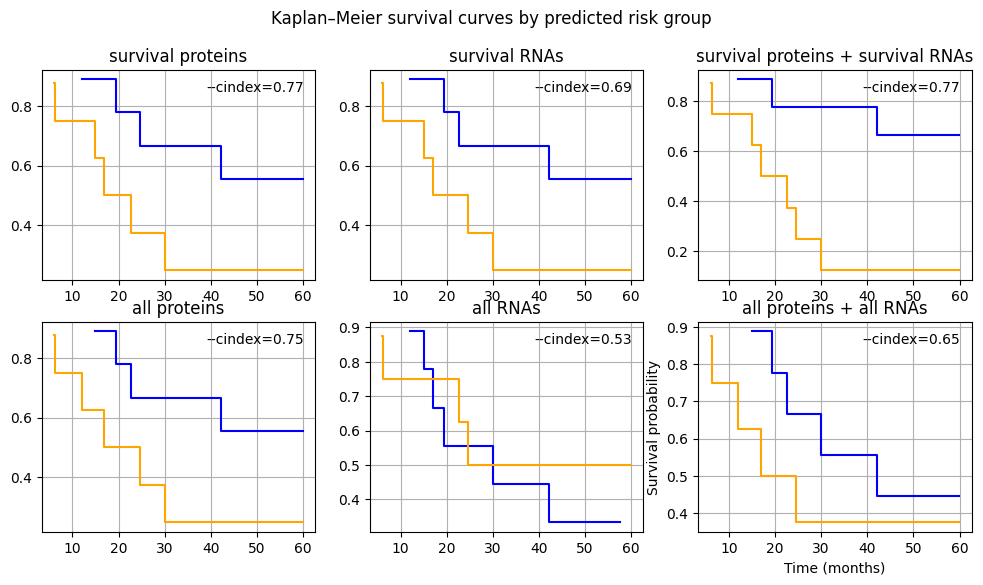

In [104]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

# low-risk/high-risk group survival proteins
axes[0, 0].step(time_low_p, surv_low_p, where="post", color='blue')
axes[0, 0].step(time_high_p, surv_high_p, where="post", color='orange')
axes[0 ,0].set_title('survival proteins')
axes[0, 0].legend(loc="upper right", title="--cindex=0.77", labels=[],fontsize=9, frameon=False)
axes[0, 0].grid(True)

# low-risk/high-risk group survival rnas
axes[0, 1].step(time_low_rna, surv_low_rna, where="post", color='blue')
axes[0, 1].step(time_high_rna, surv_high_rna, where="post", color='orange')
axes[0 ,1].set_title('survival RNAs')
axes[0, 1].legend(loc="upper right", title="--cindex=0.69", labels=[], fontsize=9, frameon=False)
axes[0, 1].grid(True)

# low-risk/high-risk group combined survival proteins + survival rnas
axes[0, 2].step(time_low_combined, surv_low_combined, where="post", color='blue')
axes[0, 2].step(time_high_combined, surv_high_combined, where="post", color='orange')
axes[0 ,2].set_title('survival proteins + survival RNAs')
axes[0, 2].legend(loc="upper right", title="--cindex=0.77", labels=[], fontsize=9, frameon=False)
axes[0, 2].grid(True)

# low-risk/high-risk group all proteins
axes[1, 0].step(time_low_p_all, surv_low_p_all, where="post", color='blue')
axes[1, 0].step(time_high_p_all, surv_high_p_all, where="post", color='orange')
axes[1 ,0].set_title('all proteins')
axes[1, 0].legend(loc="upper right", title="--cindex=0.75", labels=[], fontsize=9, frameon=False)
axes[1, 0].grid(True)

# low-risk/high-risk group all rnas
axes[1, 1].step(time_low_rna_all, surv_low_rna_all, where="post", color='blue', )
axes[1, 1].step(time_high_rna_all, surv_high_rna_all, where="post", color='orange')
axes[1 ,1].set_title('all RNAs')
axes[1, 1].legend(loc="upper right", title="--cindex=0.53", labels=[], fontsize=9, frameon=False)
axes[1, 1].grid(True)

# low-risk/high-risk group all proteins + all rnas
axes[1, 2].step(time_low_combined_all, surv_low_combined_all, where="post", color='blue')
axes[1, 2].step(time_high_combined_all, surv_high_combined_all, where="post", color='orange')
axes[1, 2].set_title('all proteins + all RNAs')
axes[1, 2].legend(loc="upper right", title="--cindex=0.65", labels=[], fontsize=9, frameon=False)
axes[1, 2].grid(True)

plt.xlabel("Time (months)")
plt.ylabel("Survival probability")

fig.suptitle(
    "Kaplan–Meier survival curves by predicted risk group",
)
plt.show()

## Conclusions
- PCA embeddings from just n=560 survival proteins produce equivalent or better risk score predictions than PCA embeddings from all proteins (n=7.6k)
- BulkRNABERT embeddings from just n=155 survival RNAs produce better risk score predictions than BulkRNABERT embeddings from all RNAs (n=19k)
- Survival protein and survival RNA embeddings better predict patient survival than all proteins or RNAs, consistent with inferences of Soltis et al. 2022
- Proteomics data is a powerful additional modality to include for multimodal survival analysis, best c-index is obtained using survival proteins, and combination of survival proteins + survival RNAs
- MFS endpoint is analyzed, same analysis can be applied to overall survival